# Import Library

In [2]:
import numpy as np
import pandas as pd
import difflib

# Pip install surprise and get it in requirements
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Get Data and fit it for Surprise

In [3]:
def load_data():
    user_game_df = pd.read_csv("../raw_data/rawg_user_games.csv")
    return user_game_df

In [4]:
def get_ratings_and_meta(df):
    filter_df = df[df['user_rating']>0]
    ratings_df = filter_df[['user_id','game_id','user_rating']]
    metadata = df[['game_id','game_name', 'released', 'metacritic', 'rawg_rating']]
    metadata['dummies'] = 0
    meta = metadata.groupby(by=['game_id','game_name', 'released', 'metacritic', 'rawg_rating']).sum().drop(columns='dummies').reset_index()
    return ratings_df, meta

In [5]:
data = load_data()
rating_df, metadata = get_ratings_and_meta(data)

/Users/zongyizhu/.pyenv/versions/3.8.6/envs/game_one/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-4-82ffb1700937>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['dummies'] = 0


In [6]:
metadata

,game_id,game_name,released,metacritic,rawg_rating
0,2,Extreme Exorcism,2015-09-23,75.0,2.77
1,4,Penarium,2015-09-22,80.0,3.20
2,12,Ironcast,2015-03-26,75.0,3.50
3,14,Tetrobot and Co.,2013-10-15,72.0,3.70
4,15,Gryphon Knight Epic,2015-08-20,55.0,0.00
...,...,...,...,...,...
3899,518596,Nioh 2 – The Complete Edition,2021-02-05,88.0,0.00
3900,520300,Atelier Ryza 2: Lost Legends & the Secret Fairy,2021-01-26,80.0,0.00
3901,527389,ArcaniA - The Complete Tale,2013-07-15,42.0,0.00
3902,528768,Persona 5 Strikers,2020-02-20,81.0,4.12


In [7]:
def get_surprise_data(df):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df, reader)
    return data

In [8]:
surprise_data = get_surprise_data(rating_df)

# Model

In [9]:
def get_train_set(surprise_df):
    return surprise_df.build_full_trainset()

In [10]:
get_train_set(surprise_data).__dict__

{'ur': defaultdict(list,
             {0: [(0, 4.0),
               (1, 5.0),
               (2, 4.0),
               (3, 4.0),
               (4, 4.0),
               (5, 4.0),
               (6, 5.0),
               (7, 4.0),
               (8, 4.0),
               (9, 3.0),
               (10, 5.0),
               (11, 4.0),
               (12, 4.0),
               (13, 4.0),
               (14, 4.0),
               (15, 4.0),
               (16, 4.0),
               (17, 4.0),
               (18, 4.0),
               (19, 4.0),
               (20, 4.0),
               (21, 4.0),
               (22, 5.0),
               (23, 4.0),
               (24, 5.0),
               (25, 3.0),
               (26, 4.0),
               (27, 4.0),
               (28, 5.0),
               (29, 5.0),
               (30, 4.0),
               (31, 4.0),
               (32, 4.0),
               (33, 3.0),
               (34, 4.0),
               (35, 5.0),
               (36, 4.0),
               (37, 

In [11]:
def run_model(surprise_df):
    svd = SVD(verbose=True, n_epochs=10)
    trainset = surprise_df.build_full_trainset()
    svd.fit(trainset)
    return svd

In [12]:
def validate_svd_model(surprise_df):
    svd = SVD(verbose=True, n_epochs=10)
    cross_validate(svd, surprise_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [13]:
model = run_model(surprise_data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [14]:
validate_svd_model(surprise_data)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 5 split(s

# Predict

In [15]:
def all_prediction_for_a_user(user_id, model, rating_df):
    predictions = []
    games = list(rating_df['game_id'].unique())
    for game in games:
        prediction = model.predict(uid=user_id, iid=game)
        predictions.append(prediction)
    return predictions

In [41]:
pred_42 = pd.DataFrame(all_prediction_for_a_user(655, model, rating_df))\
            .sort_values('est',ascending=False) \
            .drop(columns=['uid','r_ui', 'details'])
pred_42

,iid,est
404,3328,4.451643
237,4200,4.407484
210,3990,4.288833
198,22511,4.222524
238,3498,4.212367
...,...,...
964,3932,2.767092
1114,11435,2.750028
913,16355,2.699652
1765,877,2.666989


In [17]:
def get_game_id(game_name, metadata):
    
    """
    Gets the game ID for a game_name based on the closest match in the metadata dataframe.
    """
    
    existing_titles = list(metadata['game_name'].values)
    closest_titles = difflib.get_close_matches(game_name, existing_titles)
    game_id = metadata[metadata['game_name'] == closest_titles[0]]['game_id'].values[0]
    return game_id

In [18]:
def get_game_info(game_id, metadata):
    
    """
    Returns some basic information about a game given the game_id and the metadata dataframe.
    """
    
    game_info = metadata[metadata['game_id'] == game_id][['game_id','game_name', 'released', 'metacritic', 'rawg_rating']]
    return game_info.to_dict(orient='records')

In [19]:
def predict_rating(user_id, game_name, model, metadata):
    
    """
    Predicts the user_rating (on a scale of 0-5) that a user would assign to a specific game. 
    """
    
    game_id = get_game_id(game_name, metadata)
    review_prediction = model.predict(uid=user_id, iid=game_id)
    return review_prediction.est

In [20]:
def generate_recommendation(user_id, model, rating_df, metadata, thresh):
    
    """
    Generates a list of games recommendation for a user based on a rating threshold. Only
    games with a predicted rating at or above the threshold will be recommended
    """
    
    pred_user = pd.DataFrame(all_prediction_for_a_user(user_id, model, rating_df))\
            .drop(columns=['uid','r_ui', 'details'])\
            .sort_values('est',ascending=False)
        
    # game_names = list(metadata['game_name'].values)
    
    pred_user_filtered = pred_user[pred_user['est'] >= thresh]
    pred_user_filtered.rename(columns = {'iid':'game_id', 'est':'pred_r'}, inplace = True)
    
    metadata.reset_index
    
    pred_user_filtered_w_n = pred_user_filtered.merge(metadata, left_on='game_id', right_on='game_id', how='left')
    
    pred_b = pred_user_filtered_w_n.merge
    
    #for game_name in game_names:
    #    prediction = predict_purchase(user_id, game_name, model, metadata)
    #    if prediction > thresh :
    #        predictions.append({'game_name': game_name, 'prediction': prediction })
    #     if rating >= thresh:
    #         game_id = get_game_id(game_name, metadata)
    #         print(get_game_info(game_id, metadata))
    return pred_user_filtered_w_n

In [38]:
rating_per_user = data[['game_id','user_id','user_rating']]
rating_42 = rating_per_user[rating_per_user['user_id'] == 655]
rating_42

,game_id,user_id,user_rating
179559,13098,655,4
179560,44603,655,4
179561,52071,655,0
179562,48931,655,4
179563,59831,655,4
...,...,...,...
180881,5679,655,4
180882,5286,655,4
180883,3328,655,5
180884,4200,655,4


In [45]:
pred = generate_recommendation(655, model, rating_df, metadata, 4.0)
pred

/Users/zongyizhu/.pyenv/versions/3.8.6/envs/game_one/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,game_id,pred_r,game_name,released,metacritic,rawg_rating
0,3328,4.451643,The Witcher 3: Wild Hunt,2015-05-18,92.0,4.67
1,4200,4.407484,Portal 2,2011-04-18,95.0,4.62
2,3990,4.288833,The Last Of Us,2013-06-14,95.0,4.59
3,22511,4.222524,The Legend of Zelda: Breath of the Wild,2017-03-02,97.0,4.57
4,3498,4.212367,Grand Theft Auto V,2013-09-17,97.0,4.48
5,13537,4.208512,Half-Life 2,2004-11-16,96.0,4.49
6,58175,4.206111,God of War,2018-04-20,94.0,4.60
7,3636,4.198328,The Last Of Us Remastered,2014-07-29,95.0,4.70
8,28,4.185246,Red Dead Redemption 2,2018-10-26,96.0,4.57
9,2551,4.183777,Dark Souls III,2016-04-11,89.0,4.41


In [46]:
pred.merge(rating_42, left_on='game_id', right_on='game_id', how='left')

,game_id,pred_r,game_name,released,metacritic,rawg_rating,user_id,user_rating
0,3328,4.451643,The Witcher 3: Wild Hunt,2015-05-18,92.0,4.67,655,5.0
1,4200,4.407484,Portal 2,2011-04-18,95.0,4.62,655,4.0
2,3990,4.288833,The Last Of Us,2013-06-14,95.0,4.59,NaN,NaN
3,22511,4.222524,The Legend of Zelda: Breath of the Wild,2017-03-02,97.0,4.57,NaN,NaN
4,3498,4.212367,Grand Theft Auto V,2013-09-17,97.0,4.48,655,4.0
5,13537,4.208512,Half-Life 2,2004-11-16,96.0,4.49,NaN,NaN
6,58175,4.206111,God of War,2018-04-20,94.0,4.60,655,1.0
7,3636,4.198328,The Last Of Us Remastered,2014-07-29,95.0,4.70,NaN,NaN
8,28,4.185246,Red Dead Redemption 2,2018-10-26,96.0,4.57,NaN,NaN
9,2551,4.183777,Dark Souls III,2016-04-11,89.0,4.41,655,5.0


In [22]:
get_game_info(22511, metadata)

[{'game_id': 22511,
  'game_name': 'The Legend of Zelda: Breath of the Wild',
  'released': '2017-03-02',
  'metacritic': 97.0,
  'rawg_rating': 4.57}]

In [23]:
predict_rating(42, 'Zelda Breath of the wild', model, metadata)

4.801391424098733

/Users/guillaume/.pyenv/versions/3.8.6/envs/game_one_👾/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='est', ylabel='Density'>

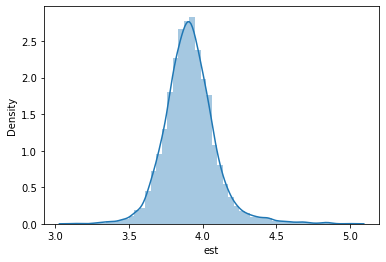

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(pred_42['est'])